In [1]:
import numpy as np
import jaxeffort
import jax
import matplotlib.pyplot as plt
import json
plt.rcParams['text.usetex'] = True

Initializing neutrino interpolants with dual-grid strategy...
Creating F_interpolant grid...
Creating dFdy_interpolant grid...
F grid: 1100 points from 0.001000 to 1000.0
dFdy grid: 20000 points from 0.001000 to 1000.0
Computing F values...
Computing dFdy values...
Creating Akima interpolators...
Dual-grid interpolants initialized successfully!
jaxeffort: Initializing multipole emulators...
  Loading pybird_mnuw0wacdm...
  pybird_mnuw0wacdm: Loaded 3/3 multipoles (l=['0', '2', '4'])


It is possible to force `jaxeffort` to update the trained emulators that come within it (in this manner, if there have been any upstream change, they will be automatically downloaded).

In [2]:
jaxeffort.force_update()

Force updating multipole emulator data...
Cleared cache directory: /home/mbonici/.jaxeffort_data
Recreated cache directory: /home/mbonici/.jaxeffort_data
Re-downloading latest version...
Downloading: 100.0% (1.7/1.7 MB)
Extracting multipole emulator data...
Extracting multipole emulator data...
Extraction complete!
  ✓ Copied multipole l=0 emulator
  ✓ Copied multipole l=2 emulator
  ✓ Copied multipole l=4 emulator
✓ All multipole emulator data ready at: /home/mbonici/.jaxeffort_data/emulators/pybird_mnuw0wacdm


True

`jaxeffort` come sbatteries included with some trained emulators. They can be accessed by

In [3]:
P0 = jaxeffort.trained_emulators["pybird_mnuw0wacdm"]["0"]
P2 = jaxeffort.trained_emulators["pybird_mnuw0wacdm"]["2"]
P4 = jaxeffort.trained_emulators["pybird_mnuw0wacdm"]["4"]

You can see their input parameter ranges by

In [4]:
P0.P11.in_MinMax

Array([[ 2.90004679e-01,  1.59999532e+00],
       [ 2.50000357e+00,  3.49999643e+00],
       [ 8.00001071e-01,  1.09999893e+00],
       [ 5.00001429e+01,  8.99998571e+01],
       [ 2.00000179e-02,  2.49999464e-02],
       [ 9.00003214e-02,  1.79999679e-01],
       [ 1.78571429e-06,  4.99998214e-01],
       [-2.99998750e+00,  4.99937500e-01],
       [-2.99998214e+00,  1.99998214e+00]], dtype=float64)

In [5]:
θ = np.array([1., 3., 0.96, 67., 0.022, 0.12, 0.06, -1., 0.])
b = np.ones(8)

cosmo_dict = {
    "ln10As": 3.0,
    "ns": 0.92,
    "H0": 57.,
    "ombh2": 0.022,
    "omch2": 0.12,
    "Mν": 0.2,
    "w0": -2.,
    "wa": -2.,
    "z": 1.2,
}


cosmo = jaxeffort.W0WaCDMCosmology(
            ln10As=cosmo_dict["ln10As"],
            ns=cosmo_dict["ns"],
            h=cosmo_dict["H0"]/100,
            omega_b=cosmo_dict["ombh2"],
            omega_c=cosmo_dict["omch2"],
            m_nu=cosmo_dict["Mν"],
            w0=cosmo_dict["w0"],
            wa=cosmo_dict["wa"]
        )
D = cosmo.D_z(cosmo_dict["z"])
P0.get_Pl(θ, b, D)

Array([ 8422.77919909, 11846.740965  , 13424.09091937, 13776.67396227,
       13340.14176789, 12444.5348679 , 11343.34540113, 10220.14021668,
        9190.13124068,  8314.86859724,  7610.01258372,  7062.37459962,
        6642.62107678,  6313.55486408,  6037.11415784,  5779.048874  ,
        5514.39332718,  5229.89270567,  4923.98947081,  4603.10476896,
        4279.39736566,  3968.16624905,  3683.30943418,  3434.55154587,
        3225.81731092,  3055.94654997,  2920.07655171,  2812.03237682,
        2725.00569737,  2650.03114375,  2577.54908451,  2502.14988294,
        2421.71023803,  2332.00233746,  2236.0603373 ,  2139.49041719,
        2040.07941294,  1947.93944786,  1861.76141308,  1783.03587218,
        1716.90503811,  1657.75193668,  1608.01374033,  1566.20870875,
        1528.04648532,  1491.97680835,  1458.95970736,  1423.6304486 ,
        1385.53328139,  1347.47052107,  1309.1484726 ,  1266.83814288,
        1225.78580041,  1188.88251872,  1153.17975454,  1116.47601924,
      

In [6]:
# Define function for P0 that depends only on θ
def P0_func(theta):
    return P0.get_Pl(theta, b, D)

# Compute Jacobian: shape (74, 9) - 74 k-bins, 9 cosmological parameters
jacobian_P0 = jax.jacfwd(P0_func)(θ)
print(f"Jacobian shape: {jacobian_P0.shape}")

Jacobian shape: (74, 9)


In [7]:
%timeit P0.get_Pl(θ, b, D)

43.5 μs ± 1.49 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


We can also use `jax` AD system to compute the jacobian of the $P_\ell$'s wrt the input parameters

In [8]:
%timeit jax.jacfwd(P0_func)(θ)

1.09 ms ± 11.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
k = P0.P11.k_grid[:,1]

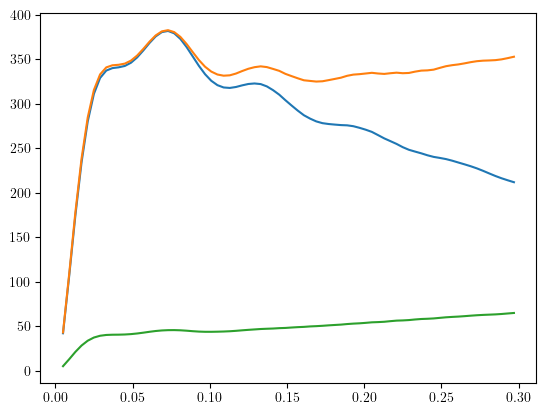

In [10]:
plt.plot(k, k*P0.get_Pl(θ, b, D))
plt.plot(k, k*P2.get_Pl(θ, b, D))
plt.plot(k, k*P4.get_Pl(θ, b, D))

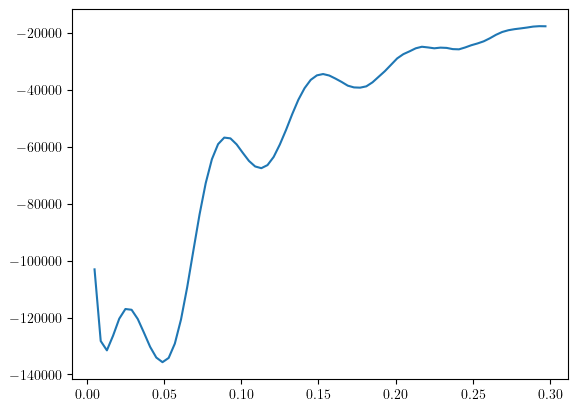

In [11]:
plt.plot(k, jacobian_P0[:,4])

In [12]:
# Generate multipoles using CLASS + PyBird (like in training data generation)
from classy import Class
from pybird.correlator import Correlator

z = cosmo_dict["z"]

# Setup CLASS parameters
cosmo_params = {
    "output": "mPk",
    "P_k_max_h/Mpc": 20.0,
    "z_pk": "0.0,3.",
    "h": cosmo_dict["H0"] / 100,
    "omega_b": cosmo_dict["ombh2"],
    "omega_cdm": cosmo_dict["omch2"],
    "ln10^{10}A_s": cosmo_dict["ln10As"],
    "n_s": cosmo_dict["ns"],
    "tau_reio": 0.0568,
    "N_ur": 2.033,
    "N_ncdm": 1,
    "m_ncdm": cosmo_dict["Mν"],
    "use_ppf": "yes",
    "w0_fld": cosmo_dict["w0"],
    "wa_fld": cosmo_dict["wa"],
    "fluid_equation_of_state": "CLP",
    "cs2_fld": 1.,
    "Omega_Lambda": 0.,
    "Omega_scf": 0.
}

# Initialize CLASS and compute linear power spectrum
M = Class()
M.set(cosmo_params)
M.compute()

# Generate k values and compute linear power spectrum
kk = 10 ** np.linspace(-5, 0, 200)
pk_lin = [M.pk_cb(k * M.h(), z) * M.h()**3 for k in kk]

# Get growth factors
D1 = M.scale_independent_growth_factor(z)
f1 = M.scale_independent_growth_factor_f(z)

# Initialize PyBird Correlator
N = Correlator()
dk = 0.004
kd = np.arange(0.005, 0.3, dk)

# Set correlator parameters
N.set({
    "output": "bPk",
    "multipole": 3,
    "kmax": 0.3,
    "xdata": kd,
    "km": 0.7,
    "kr": 0.35,
    "nd": 3e-4,
    "eft_basis": "eftoflss",
    "with_stoch": True,
    "with_bias": False,
    "with_resum": True
})

# Compute correlator
N.compute({
    "kk": kk,
    "pk_lin": pk_lin,
    "f": f1
})

# Get the multipole components (matching training data)
P11l = N.bird.P11l
Ploopl = N.bird.Ploopl
Pctl = N.bird.Pctl

print(f"CLASS+PyBird computation complete!")
print(f"P11l shape: {P11l.shape}")
print(f"Ploopl shape: {Ploopl.shape}")
print(f"Pctl shape: {Pctl.shape}")

CLASS+PyBird computation complete!
P11l shape: (3, 3, 74)
Ploopl shape: (3, 12, 74)
Pctl shape: (3, 6, 74)


In [13]:
# Compare emulator vs CLASS+PyBird
# Note: Need to apply bias contraction to get final multipoles from components

# For emulator: convert parameters to match expected format
θ_emu = np.array([
    cosmo_dict["z"],
    cosmo_dict["ln10As"],
    cosmo_dict["ns"],
    cosmo_dict["H0"],
    cosmo_dict["ombh2"],
    cosmo_dict["omch2"],
    cosmo_dict["Mν"],
    cosmo_dict["w0"],
    cosmo_dict["wa"]
])

# Compute with emulator
P0_emu = P0.get_Pl(θ_emu, b, D)
P2_emu = P2.get_Pl(θ_emu, b, D)
P4_emu = P4.get_Pl(θ_emu, b, D)

print(f"Emulator P0 shape: {P0_emu.shape}")
print(f"PyBird P11l shape (multipoles): {P11l.shape}")
print(f"\nNote: PyBird outputs components (P11, Ploop, Pct) that need bias contraction")
print(f"The emulator learns this full pipeline: CLASS → PyBird → bias contraction → multipoles")

Emulator P0 shape: (74,)
PyBird P11l shape (multipoles): (3, 3, 74)

Note: PyBird outputs components (P11, Ploop, Pct) that need bias contraction
The emulator learns this full pipeline: CLASS → PyBird → bias contraction → multipoles


In [14]:
# Apply bias contraction to PyBird components (as jaxeffort does internally)
b1, b2, b3, b4, b5, b6, b7, f = b[:8]  # Extract 8 bias parameters

# Create bias combinations (21 terms matching training)
biases = np.array([
    b1**2, 2*b1*f, f**2, 1., b1, b2, b3, b4,
    b1*b1, b1*b2, b1*b3, b1*b4,
    b2*b2, b2*b4, b4*b4,
    2*b1*b5, 2*b1*b6, 2*b1*b7,
    2*f*b5, 2*f*b6, 2*f*b7
])

# Extract and reshape components for each multipole (following trainer.jl logic)
# Stack P11 (3 terms), Ploop (12 terms), Pct (6 terms) = 21 total per k-bin
P0_stacked = np.hstack([P11l[0].T, Ploopl[0].T, Pctl[0].T])
P0_pybird = np.dot(P0_stacked, biases)  # ℓ=0

P2_stacked = np.hstack([P11l[1].T, Ploopl[1].T, Pctl[1].T])
P2_pybird = np.dot(P2_stacked, biases)  # ℓ=2

P4_stacked = np.hstack([P11l[2].T, Ploopl[2].T, Pctl[2].T])
P4_pybird = np.dot(P4_stacked, biases)  # ℓ=2

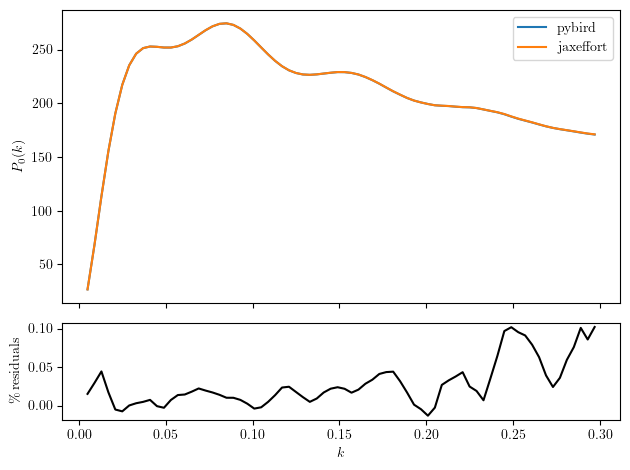

In [26]:
ratio  = P0_pybird / P0_emu  

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(k, k*P0_pybird, label=r'$\mathrm{pybird}$')
ax_top.plot(k, k*P0_emu, label=r'$\mathrm{jaxeffort}$')
ax_top.set_ylabel(r'$P_0(k)$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(k, 100*(1-ratio), color='k')
ax_bot.set_xlabel(r'$k$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()

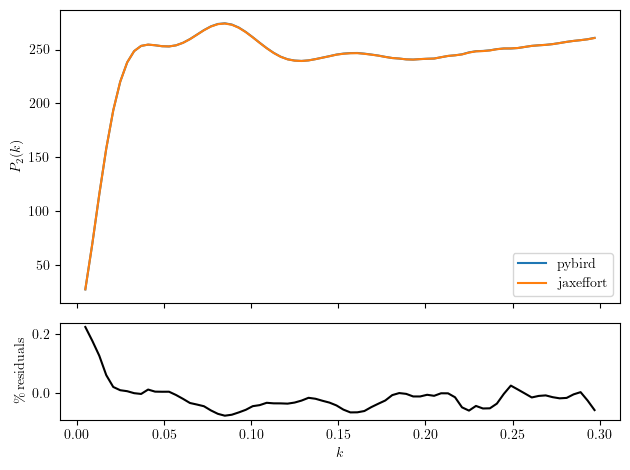

In [27]:
ratio  = P2_pybird / P2_emu  

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(k, k*P2_pybird, label=r'$\mathrm{pybird}$')
ax_top.plot(k, k*P2_emu, label=r'$\mathrm{jaxeffort}$')
ax_top.set_ylabel(r'$P_2(k)$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(k, 100*(1-ratio), color='k')
ax_bot.set_xlabel(r'$k$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()

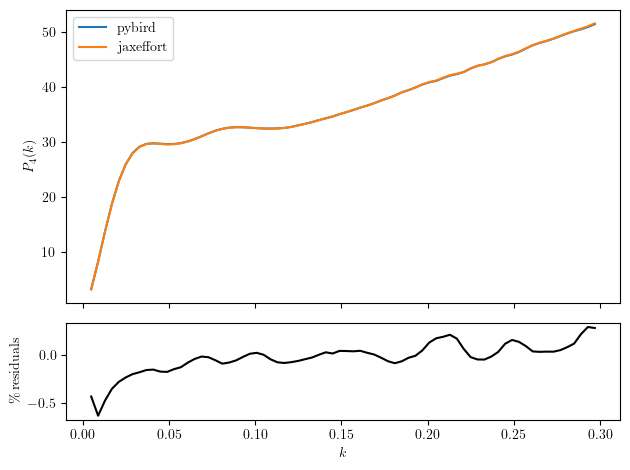

In [28]:
ratio  = P4_pybird / P4_emu  

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(k, k*P4_pybird, label=r'$\mathrm{pybird}$')
ax_top.plot(k, k*P4_emu, label=r'$\mathrm{jaxeffort}$')
ax_top.set_ylabel(r'$P_4(k)$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(k, 100*(1-ratio), color='k')
ax_bot.set_xlabel(r'$k$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()